In [58]:
import pandas as pd

pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

Setup Complete


# Introduction
We're going to use the dataset on [Kaggle](https://www.kaggle.com/datasets/federalreserve/interest-rates). It contains interest rate data since 1954. The federal funds rate is the interest rate at which banks trade federal funds overnight. The Fed sets a **target** for this, but due to the free market, the **effective** funds rate will be different. Since we're predicting the Fed's decision, we're going to predict the target rate.

According to the dataset description:
> The unemployment rate represents the number of unemployed as a seasonally adjusted percentage of the labor force. The inflation rate reflects the monthly change in the Consumer Price Index of products excluding food and energy.

In [59]:
df = pd.read_csv('index.csv', parse_dates={'Date': ['Year', 'Month', 'Day']}, index_col='Date')
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

# Data Cleaning
First, let's see how many missing values we have.

In [60]:
df.isnull().sum()

Federal Funds Target Rate       442
Federal Funds Upper Target      801
Federal Funds Lower Target      801
Effective Federal Funds Rate    152
Real GDP (Percent Change)       654
Unemployment Rate               152
Inflation Rate                  194
Year                              0
Month                             0
Day                               0
dtype: int64

### Federal Funds Upper/Lower Target
It looks like there are a lot of missing values in `Federal Funds Upper Target` and `Federal Funds Lower Target`. Since this range system was only adopted more recently, we can simply convert them back to single values by calculating their average. Also, there are way too many missing values in `Real GDP (Percent Change)` so we're just going to drop it.

In [61]:
df.loc[df['Federal Funds Target Rate'].isna(), 'Federal Funds Target Rate'] = (df['Federal Funds Upper Target'] + df['Federal Funds Lower Target']) / 2
df = df.drop(['Federal Funds Upper Target', 'Federal Funds Lower Target', 'Real GDP (Percent Change)'], axis=1)
print(df.head())

            Federal Funds Target Rate  Effective Federal Funds Rate  \
Date                                                                  
1954-07-01                        NaN                          0.80   
1954-08-01                        NaN                          1.22   
1954-09-01                        NaN                          1.06   
1954-10-01                        NaN                          0.85   
1954-11-01                        NaN                          0.83   

            Unemployment Rate  Inflation Rate  Year  Month  Day  
Date                                                             
1954-07-01                5.8             NaN  1954      7    1  
1954-08-01                6.0             NaN  1954      8    1  
1954-09-01                6.1             NaN  1954      9    1  
1954-10-01                5.7             NaN  1954     10    1  
1954-11-01                5.3             NaN  1954     11    1  


### Federal Funds Target Rate, Unemployment Rate, Inflation Rate
Now, let's graph the number of missing `Federal Funds Target Rate`, `Unemployment Rate`, and `Inflation Rate` values by year.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

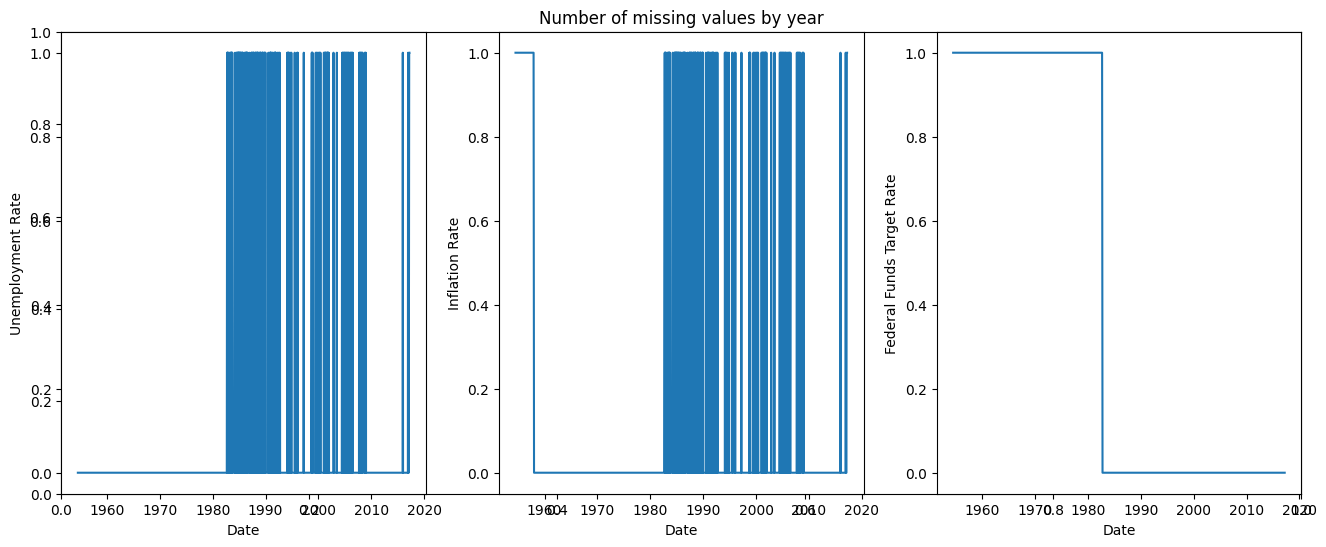

In [62]:
plt.figure(figsize=(16, 6))
plt.title('Number of missing values by year')
# plot 3 graphs separately
plt.subplot(1, 3, 1)
sns.lineplot(data=df['Unemployment Rate'].isnull())
plt.subplot(1, 3, 2)
sns.lineplot(data=df['Inflation Rate'].isnull())
plt.subplot(1, 3, 3)
sns.lineplot(data=df['Federal Funds Target Rate'].isnull())

plt.show()


It seems that the missing values for `Inflation Rate` and `Unemployment Rate` are very erratic, so we can probably just generically impute them later. 
### Effective Federal Funds Rate
However, for `Federal Funds Target Rate`, we can see that the missing values are mostly in the 1950s to the 1970s. Let's see if the years with missing values in `Federal Funds Target Rate` also have missing values in `Effective Federal Funds Rate`.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

<Axes: title={'center': 'Number of missing values by year'}, xlabel='Date', ylabel='Federal Funds Target Rate'>

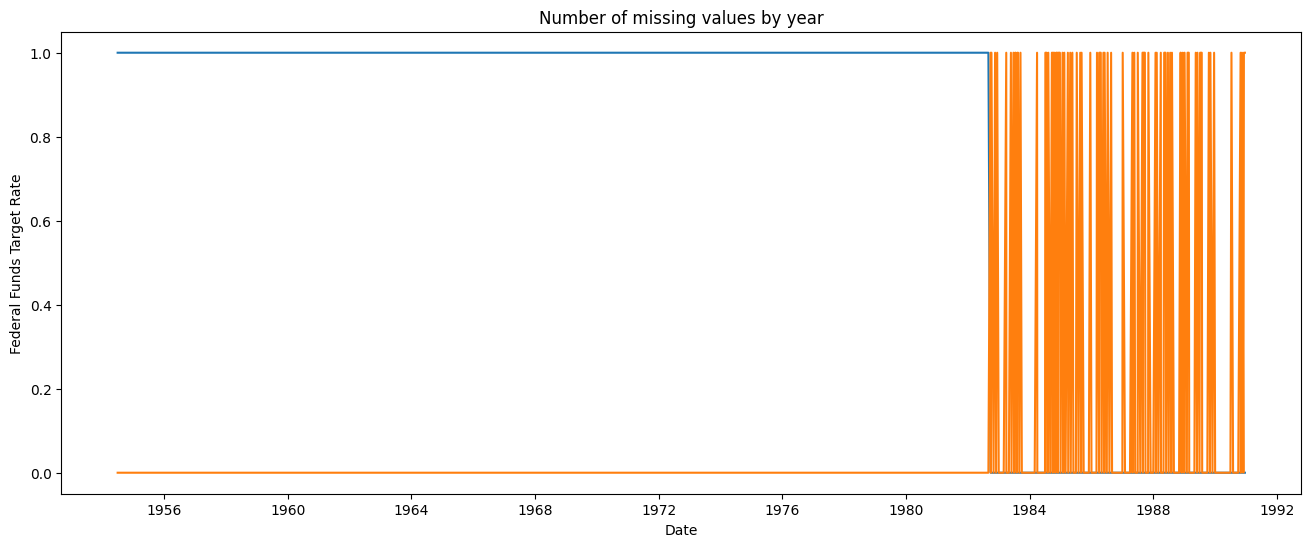

In [63]:
plt.figure(figsize=(16, 6))
plt.title('Number of missing values by year')
sns.lineplot(data=df.loc['1950':'1990', 'Federal Funds Target Rate'].isnull())
sns.lineplot(data=df.loc['1950':'1990', 'Effective Federal Funds Rate'].isnull())


In [64]:
print(df.loc[df['Federal Funds Target Rate'].isna(), 'Effective Federal Funds Rate'].notna().sum() / df['Federal Funds Target Rate'].isna().sum())

1.0


It looks like values in `Effective Federal Funds Rate` are always present if the values from `Federal Funds Target Rate` are missing. Therefore, we can just impute the missing values in `Federal Funds Target Rate` with the values in `Effective Federal Funds Rate`, since they are usually very close to each other.

In [65]:
df.loc[df['Federal Funds Target Rate'].isna(), 'Federal Funds Target Rate'] = df.loc[df['Federal Funds Target Rate'].isna(), 'Effective Federal Funds Rate']
print(df.isnull().sum())

Federal Funds Target Rate         0
Effective Federal Funds Rate    152
Unemployment Rate               152
Inflation Rate                  194
Year                              0
Month                             0
Day                               0
dtype: int64


Since we're not going to know what the `Effective Federal Funds Rate` is when predicting in the real world, we can drop that column now.

In [66]:
df = df.drop('Effective Federal Funds Rate', axis=1)
print(df.isnull().sum())

Federal Funds Target Rate      0
Unemployment Rate            152
Inflation Rate               194
Year                           0
Month                          0
Day                            0
dtype: int64


All that's left is to impute the missing values in `Inflation Rate` and `Unemployment Rate`. We can't derive these values from the existing data, so we'll just use the mean of the previous and next values.

In [67]:
df['Inflation Rate'] = df['Inflation Rate'].interpolate()
df['Unemployment Rate'] = df['Unemployment Rate'].interpolate()
print(df.isnull().sum())

Federal Funds Target Rate     0
Unemployment Rate             0
Inflation Rate               42
Year                          0
Month                         0
Day                           0
dtype: int64


Let's see where these 42 missing `Inflation Rate` values are.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

<Axes: xlabel='Date', ylabel='Inflation Rate'>

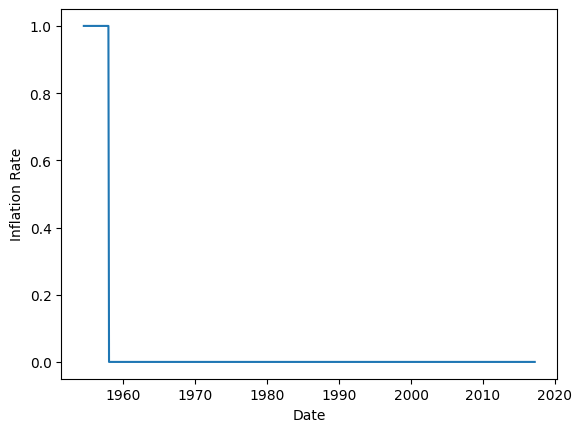

In [68]:
sns.lineplot(data=df['Inflation Rate'].isna())

Looks like inflation data wasn't tracked in the 1950s. Since there's only 42 rows and I really want to measure with inflation rate, let's just drop them.

In [69]:
df = df.dropna(subset=['Inflation Rate'])
print(df.isnull().sum())

Federal Funds Target Rate    0
Unemployment Rate            0
Inflation Rate               0
Year                         0
Month                        0
Day                          0
dtype: int64


# Data Analysis & Feature Engineering
## Correlations
We now only have two columns to predict from: `Unemployment Rate` and `Inflation Rate`. Let's see how they correlate with the `Federal Funds Target Rate`.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

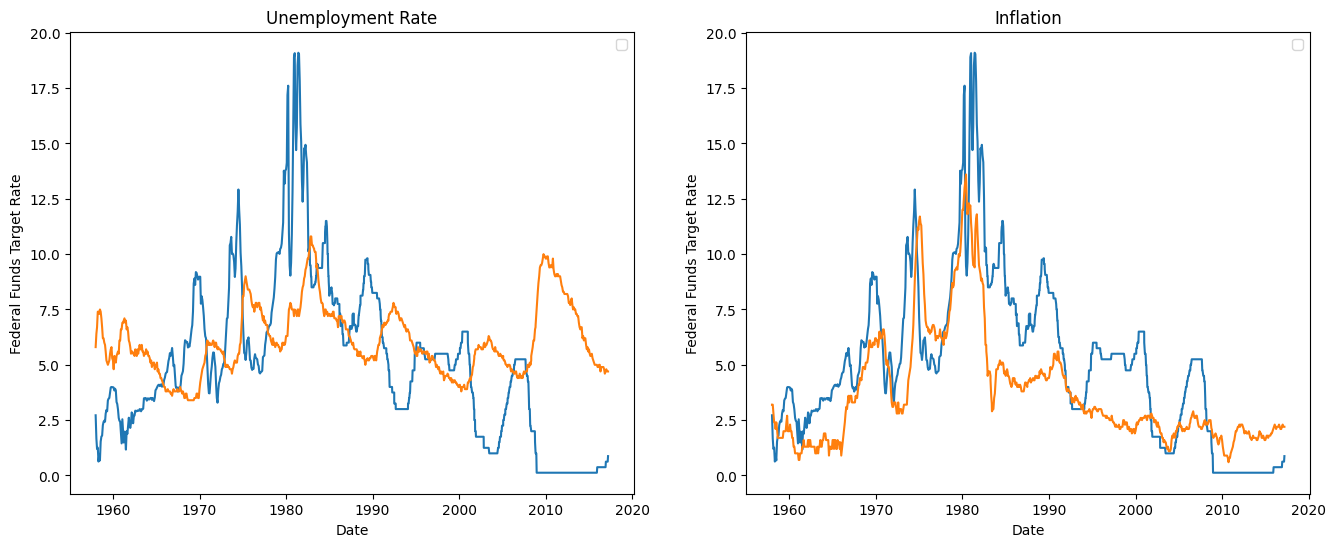

In [70]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=df['Federal Funds Target Rate'])
sns.lineplot(data=df['Unemployment Rate'])
plt.title('Unemployment Rate')
plt.legend()
plt.subplot(122)
sns.lineplot(data=df['Federal Funds Target Rate'])
sns.lineplot(data=df['Inflation Rate'])
plt.title('Inflation')
plt.legend()
plt.show()


It looks like `Inflation Rate` is more correlated with `Federal Funds Target Rate` than `Unemployment Rate`.
## Data Binning
Let's see how the time values are distributed; particiularly, the day.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

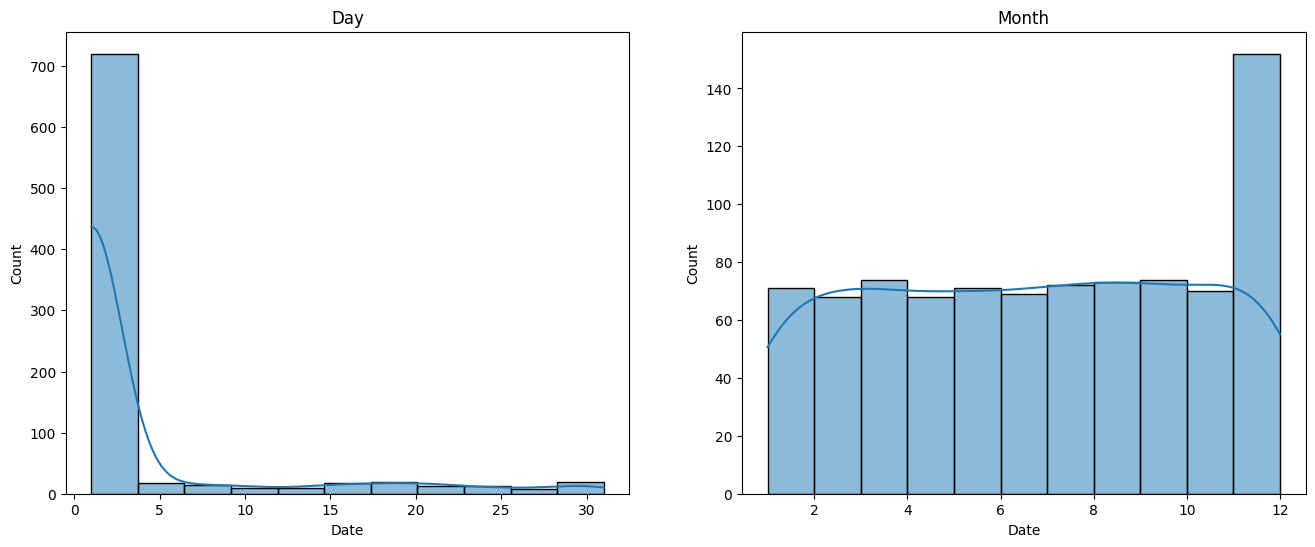

In [71]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.histplot(df.index.day, kde=True)
plt.title('Day')
plt.subplot(122)
sns.histplot(df.index.month, kde=True)
plt.title('Month')
plt.show()


It looks like the Fed meets pretty consistently every month, but more during the later part of the year. In addition, most of the meetings are on the 1st day of the month. Since we want to make the data as smooth as possible, let's bin the data into months.

In [72]:
# group the data by month and year
df = df.groupby(['Year', 'Month']).mean()
print(df.head())

            Federal Funds Target Rate  Unemployment Rate  Inflation Rate  Day
Year Month                                                                   
1958 1                           2.72                5.8             3.2  1.0
     2                           1.67                6.4             3.2  1.0
     3                           1.20                6.7             2.8  1.0
     4                           1.26                7.4             2.4  1.0
     5                           0.63                7.4             2.4  1.0


There's not much else to do, since the data is all numerical and there aren't many columns.

# Model Building
## Train/Validation/Test Split
First, we'll split the data. I'll do a traditional 60/20/20 split, but we'll combine the training and validation data once we're done tuning the early stopping hyperparameter.

In [73]:
from sklearn.model_selection import train_test_split

# split the data into train, validation, and test sets
train, test = train_test_split(df, test_size=0.4, shuffle=False)
validation, test = train_test_split(test, test_size=0.5, shuffle=False)
x_train, y_train = train.drop('Federal Funds Target Rate', axis=1), train['Federal Funds Target Rate']
x_val, y_val = validation.drop('Federal Funds Target Rate', axis=1), validation['Federal Funds Target Rate']
x_test, y_test = test.drop('Federal Funds Target Rate', axis=1), test['Federal Funds Target Rate']
print(train.shape, validation.shape, test.shape)

(426, 4) (142, 4) (143, 4)


Now let's define the model. We're going to use recurrent neural networks (RNNs) since they work very well with time-series data. We'll use long short-term memory (LSTM) layers since they're the most popular and are pretty accurate.

In [76]:
from keras.src.layers import CuDNNLSTM, Dense
from keras import Sequential, Input


def make_model(trial):
    n_hidden = trial.suggest_int('n_hidden', 1, 4)
    n_units = trial.suggest_int('n_units', 32, 128)
    model = Sequential()
    model.add(Input(shape=(x_train.shape[1], 1)))
    for i in range(n_hidden):
        model.add(CuDNNLSTM(n_units, return_sequences=True if i < n_hidden - 1 else False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


Lastly, we'll be making use of Optuna to tune hyperparameters for us.

In [ ]:
from optuna.visualization import plot_optimization_history


def objective(trial):
    model = make_model(trial)
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, verbose=0)
    return model.evaluate(x_val, y_val, verbose=0)

import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)
print(study.best_params)
plot_optimization_history(study)

[I 2023-09-22 10:02:25,987] A new study created in memory with name: no-name-77eceae3-9004-491d-9b20-16ef414511d7
[I 2023-09-22 10:03:53,721] Trial 6 finished with value: 4.575934410095215 and parameters: {'n_hidden': 1, 'n_units': 96}. Best is trial 6 with value: 4.575934410095215.
[I 2023-09-22 10:04:30,277] Trial 1 finished with value: 5.777157783508301 and parameters: {'n_hidden': 2, 'n_units': 46}. Best is trial 6 with value: 4.575934410095215.
[I 2023-09-22 10:04:33,848] Trial 4 finished with value: 4.648090839385986 and parameters: {'n_hidden': 2, 'n_units': 115}. Best is trial 6 with value: 4.575934410095215.
[I 2023-09-22 10:05:05,952] Trial 5 finished with value: 4.536988735198975 and parameters: {'n_hidden': 3, 'n_units': 80}. Best is trial 5 with value: 4.536988735198975.
[I 2023-09-22 10:05:20,791] Trial 3 finished with value: 3.3539767265319824 and parameters: {'n_hidden': 3, 'n_units': 34}. Best is trial 3 with value: 3.3539767265319824.


In [ ]:
best_model = make_model(study.best_trial)
best_model.evaluate(x_test, y_test)